# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977

#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_TRAIN_AE = True #  True
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = False # False

EPOCHS_AE = 2#30
PATIENCE_AE = 0#10
LIST_UNITS_AE = [64]
LIST_UNITS_ENC_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat = pd.read_csv(path_save_df_feat_std)
df_feat

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,TRAIN
0,0.017908,-0.008003,-0.060812,0.084983,-0.040537,0.020570,-0.145125,-0.036057,8.846620,8.214576,...,0.365815,1.365699,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
1,0.017908,-0.036147,-0.072985,0.056754,-0.073969,-0.017147,-0.176665,-0.069244,8.833510,8.202341,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
2,0.017908,0.028211,-0.050678,0.093063,-0.067464,-0.010977,-0.162048,-0.034545,8.835654,8.204342,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
3,0.017908,0.110746,0.019358,0.100115,0.002524,0.051456,-0.076226,0.055714,8.857356,8.224595,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
4,0.017908,-0.062306,-0.070957,0.031525,-0.039973,-0.003436,-0.151681,-0.023642,8.838276,8.206789,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89373,0.017908,0.350024,0.299494,0.077356,-0.978290,-1.178982,-0.135292,-0.095671,-0.413026,-0.565622,...,0.706904,-1.225008,0.878249,1.108851,0.130179,1.395178,-0.050339,-0.00158,0.000813,0.0
89374,0.017908,0.055462,0.054787,-0.038722,-0.824021,-1.128032,-0.100324,-0.058923,-0.407057,-0.560095,...,0.999805,-1.000268,0.878249,1.108851,0.130179,1.395178,-0.050339,-0.00158,0.000813,0.0
89375,0.017908,0.255747,0.184083,0.065202,-0.654754,-0.968274,0.122441,0.175180,-0.369031,-0.524882,...,0.999805,-1.000268,0.878249,1.108851,0.130179,1.395178,-0.050339,-0.00158,0.000813,0.0
89376,0.017908,0.075838,0.091534,0.056278,-0.613577,-0.929410,0.176631,0.283069,-0.341589,-0.499273,...,0.999805,-1.000268,0.878249,1.108851,0.130179,1.395178,-0.050339,-0.00158,0.000813,0.0


## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [7]:
df_feat.shape[0]

89378

In [8]:
df_feat[df_feat["TRAIN"] == True]

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,TRAIN
0,0.017908,-0.008003,-0.060812,0.084983,-0.040537,0.020570,-0.145125,-0.036057,8.846620,8.214576,...,0.365815,1.365699,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
1,0.017908,-0.036147,-0.072985,0.056754,-0.073969,-0.017147,-0.176665,-0.069244,8.833510,8.202341,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
2,0.017908,0.028211,-0.050678,0.093063,-0.067464,-0.010977,-0.162048,-0.034545,8.835654,8.204342,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
3,0.017908,0.110746,0.019358,0.100115,0.002524,0.051456,-0.076226,0.055714,8.857356,8.224595,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
4,0.017908,-0.062306,-0.070957,0.031525,-0.039973,-0.003436,-0.151681,-0.023642,8.838276,8.206789,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89013,0.017908,0.110966,0.029260,0.078202,0.038613,0.334726,-0.132941,0.035636,-0.610201,-0.464391,...,-0.366254,1.365699,1.410702,0.003136,0.418946,1.333604,-0.050339,-0.00158,0.000813,1.0
89014,0.017908,-0.163353,-0.028247,-0.069829,-0.092001,0.210470,-0.280274,-0.119402,-0.638944,-0.491436,...,-0.366254,1.365699,1.410702,0.003136,0.418946,1.333604,-0.050339,-0.00158,0.000813,1.0
89015,0.017908,0.118578,0.027255,0.042297,-0.020304,0.278677,-0.122918,-0.021133,-0.623166,-0.476590,...,-0.366254,1.365699,1.410702,0.003136,0.418946,1.333604,-0.050339,-0.00158,0.000813,1.0
89016,0.017908,0.048225,-0.023682,0.066665,0.001320,0.299249,-0.066502,0.008505,-0.618408,-0.472113,...,-0.366254,1.365699,1.410702,0.003136,0.418946,1.333604,-0.050339,-0.00158,0.000813,1.0


In [9]:
df_feat[df_feat["TRAIN"] == False]

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,TRAIN
89018,0.017908,-0.130916,0.012885,-0.037294,-0.344969,-0.603976,-0.526203,-0.057847,-0.941176,-0.774608,...,-1.000244,-1.000268,1.410702,0.003136,0.418946,1.333604,-0.050339,-0.00158,0.000813,0.0
89019,0.017908,0.057794,-0.028322,-0.055645,-0.316571,-0.514701,-0.489178,-0.018789,-0.935008,-0.768804,...,-1.000244,-1.000268,1.410702,0.003136,0.418946,1.333604,-0.050339,-0.00158,0.000813,0.0
89020,0.017908,0.317137,0.259891,0.035042,-0.132716,-0.311065,-0.209232,0.249159,-0.888372,-0.724920,...,-1.000244,-1.000268,1.410702,0.003136,0.418946,1.333604,-0.050339,-0.00158,0.000813,0.0
89021,0.017908,0.071162,-0.002738,0.001461,-0.094647,-0.275062,-0.159580,0.258901,-0.880101,-0.717137,...,-1.000244,-1.000268,1.410702,0.003136,0.418946,1.333604,-0.050339,-0.00158,0.000813,0.0
89022,0.017908,-0.126810,-0.011085,-0.033176,-0.198803,-0.373566,-0.295427,0.107291,-0.902731,-0.738432,...,-1.000244,-1.000268,1.410702,0.003136,0.418946,1.333604,-0.050339,-0.00158,0.000813,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89373,0.017908,0.350024,0.299494,0.077356,-0.978290,-1.178982,-0.135292,-0.095671,-0.413026,-0.565622,...,0.706904,-1.225008,0.878249,1.108851,0.130179,1.395178,-0.050339,-0.00158,0.000813,0.0
89374,0.017908,0.055462,0.054787,-0.038722,-0.824021,-1.128032,-0.100324,-0.058923,-0.407057,-0.560095,...,0.999805,-1.000268,0.878249,1.108851,0.130179,1.395178,-0.050339,-0.00158,0.000813,0.0
89375,0.017908,0.255747,0.184083,0.065202,-0.654754,-0.968274,0.122441,0.175180,-0.369031,-0.524882,...,0.999805,-1.000268,0.878249,1.108851,0.130179,1.395178,-0.050339,-0.00158,0.000813,0.0
89376,0.017908,0.075838,0.091534,0.056278,-0.613577,-0.929410,0.176631,0.283069,-0.341589,-0.499273,...,0.999805,-1.000268,0.878249,1.108851,0.130179,1.395178,-0.050339,-0.00158,0.000813,0.0


In [10]:
for ser in df_feat.values[:,:-1]:
    print(ser.shape)
    break

(102,)


In [11]:
df_feat[df_feat["TRAIN"]==True].values.shape

(89018, 103)

In [12]:
class TimeSeriesDatasetForAe(tf.data.Dataset):

    def _generator(data_matrix, seq_length, len_pred):
        
        num_elements = data_matrix.shape[0] # nb samples

        for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred),
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            yield (out_matrix, out_matrix)
       

    def __new__(cls, data_matrix, seq_length, len_pred):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=(
                tf.TensorSpec(
                    shape = (seq_length, data_matrix.shape[1]),
                    dtype = tf.float32,
                ),
                tf.TensorSpec(
                    shape = (seq_length, data_matrix.shape[1]),
                    dtype = tf.float32,
                ),
            ),
            args=(data_matrix, seq_length, len_pred),
        )

In [13]:
class TimeSeriesDataset(tf.data.Dataset):

    def _generator(data_matrix, seq_length, len_pred):
        
        num_elements = data_matrix.shape[0] # nb samples

        for start, stop, start_label, stop_label in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred), 
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements),
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            out_matrix_label = data_matrix[start_label:stop_label, :].copy()
            #np.swapaxes(out_matrix_label, 0, 1).squeeze()
            yield (out_matrix, out_matrix_label)
       

    def __new__(cls, data_matrix, seq_length, len_pred):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=(
                tf.TensorSpec(
                    shape = (seq_length, data_matrix.shape[1]),
                    dtype = tf.float32,
                ),
                tf.TensorSpec(
                    shape = (len_pred, data_matrix.shape[1]),
                    dtype = tf.float32,
                ),
            ),
            args=(data_matrix, seq_length, len_pred),
        )

In [14]:

arr_train_ae = df_feat[df_feat["TRAIN"]==True].values[:,:-1].astype(np.float32)
arr_test_ae = df_feat[df_feat["TRAIN"]==False].values[:,:-1].astype(np.float32)
print(arr_train_ae.shape)
print(arr_test_ae.shape)
train_data_ae = TimeSeriesDatasetForAe(arr_train_ae, PAST_HISTORY, FUTURE_TARGET)
test_data_ae = TimeSeriesDatasetForAe(arr_test_ae, PAST_HISTORY, FUTURE_TARGET)

(89018, 102)
(360, 102)


In [15]:
K=0
for s_curr in train_data_ae:
    K+=1
    if K == 1:
        print(s_curr)
        break

(<tf.Tensor: shape=(72, 102), dtype=float32, numpy=
array([[ 0.01790837, -0.00800251, -0.06081248, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       [ 0.01790837, -0.03614686, -0.07298538, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       [ 0.01790837,  0.02821136, -0.05067777, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       ...,
       [ 0.01790837,  0.04729332, -0.03448883, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       [ 0.01790837,  0.04026413, -0.05069377, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       [ 0.01790837,  0.02016474, -0.07095935, ..., -0.05033869,
        -0.00157999,  0.0008129 ]], dtype=float32)>, <tf.Tensor: shape=(72, 102), dtype=float32, numpy=
array([[ 0.01790837, -0.00800251, -0.06081248, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       [ 0.01790837, -0.03614686, -0.07298538, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       [ 0.01790837,  0.02821136, -0.05067777, ..., -0.05033869,
  

In [16]:
arr_train = df_feat[df_feat["TRAIN"]==True].values[:,:-1].astype(np.float32)
arr_test = df_feat[df_feat["TRAIN"]==False].values[:,:-1].astype(np.float32)
print(arr_train.shape)
print(arr_test.shape)
train_data = TimeSeriesDataset(arr_train, PAST_HISTORY, FUTURE_TARGET)
test_data = TimeSeriesDataset(arr_test, PAST_HISTORY, FUTURE_TARGET)

(89018, 102)
(360, 102)


In [17]:
K=0
for s_curr in train_data:
    K+=1
    if K == 1:
        print(s_curr)
        break

(<tf.Tensor: shape=(72, 102), dtype=float32, numpy=
array([[ 0.01790837, -0.00800251, -0.06081248, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       [ 0.01790837, -0.03614686, -0.07298538, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       [ 0.01790837,  0.02821136, -0.05067777, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       ...,
       [ 0.01790837,  0.04729332, -0.03448883, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       [ 0.01790837,  0.04026413, -0.05069377, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       [ 0.01790837,  0.02016474, -0.07095935, ..., -0.05033869,
        -0.00157999,  0.0008129 ]], dtype=float32)>, <tf.Tensor: shape=(15, 102), dtype=float32, numpy=
array([[ 0.01790837, -0.03709466, -0.07298644, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       [ 0.01790837,  0.00811033, -0.07399928, ..., -0.05033869,
        -0.00157999,  0.0008129 ],
       [ 0.01790837,  0.07241959, -0.01827243, ..., -0.05033869,
  

In [18]:
df_test = pd.DataFrame(s_curr[0].numpy())
df_test

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,0.017908,-0.008003,-0.060812,0.084983,-0.040537,0.020570,-0.145125,-0.036057,8.846621,8.214576,...,1.090484,0.365815,1.365699,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
1,0.017908,-0.036147,-0.072985,0.056754,-0.073969,-0.017147,-0.176665,-0.069244,8.833509,8.202341,...,1.090484,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
2,0.017908,0.028211,-0.050678,0.093063,-0.067464,-0.010977,-0.162048,-0.034545,8.835654,8.204342,...,1.090484,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
3,0.017908,0.110746,0.019358,0.100115,0.002524,0.051456,-0.076226,0.055714,8.857356,8.224595,...,1.090484,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
4,0.017908,-0.062306,-0.070957,0.031525,-0.039973,-0.003436,-0.151681,-0.023642,8.838276,8.206789,...,1.090484,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.017908,0.017150,-0.063869,0.075951,-0.082729,-0.076375,0.028184,0.065076,8.807801,8.178349,...,1.090484,-1.366278,0.365724,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
68,0.017908,0.000073,-0.073999,0.093085,-0.090663,-0.088691,0.011212,0.053184,8.803520,8.174354,...,1.090484,-1.366278,0.365724,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
69,0.017908,0.047293,-0.034489,0.111221,-0.069004,-0.066106,0.057895,0.082913,8.810655,8.181012,...,1.090484,-1.366278,0.365724,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
70,0.017908,0.040264,-0.050694,0.111221,-0.040822,-0.050359,0.079597,0.105715,8.816128,8.186119,...,1.090484,-1.366278,0.365724,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813


In [19]:
df_feat.iloc[:72]

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,TRAIN
0,0.017908,-0.008003,-0.060812,0.084983,-0.040537,0.020570,-0.145125,-0.036057,8.846620,8.214576,...,0.365815,1.365699,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
1,0.017908,-0.036147,-0.072985,0.056754,-0.073969,-0.017147,-0.176665,-0.069244,8.833510,8.202341,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
2,0.017908,0.028211,-0.050678,0.093063,-0.067464,-0.010977,-0.162048,-0.034545,8.835654,8.204342,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
3,0.017908,0.110746,0.019358,0.100115,0.002524,0.051456,-0.076226,0.055714,8.857356,8.224595,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
4,0.017908,-0.062306,-0.070957,0.031525,-0.039973,-0.003436,-0.151681,-0.023642,8.838276,8.206789,...,-0.000220,1.413886,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.017908,0.017150,-0.063869,0.075951,-0.082729,-0.076375,0.028184,0.065076,8.807801,8.178348,...,-1.366278,0.365724,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
68,0.017908,0.000073,-0.073999,0.093085,-0.090663,-0.088691,0.011212,0.053184,8.803520,8.174354,...,-1.366278,0.365724,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
69,0.017908,0.047293,-0.034489,0.111221,-0.069004,-0.066106,0.057895,0.082913,8.810655,8.181012,...,-1.366278,0.365724,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
70,0.017908,0.040264,-0.050694,0.111221,-0.040822,-0.050359,0.079597,0.105715,8.816127,8.186119,...,-1.366278,0.365724,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0


In [20]:
df_test = pd.DataFrame(s_curr[1].numpy())
df_test

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,0.017908,-0.037095,-0.072986,0.056812,-0.062836,-0.079099,0.051289,0.025945,8.803759,8.174576,...,1.090484,-1.366278,0.365724,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
1,0.017908,0.008110,-0.073999,0.088049,-0.064996,-0.082856,0.040916,-0.006738,8.801143,8.172134,...,1.090484,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
2,0.017908,0.072420,-0.018272,0.108197,-0.004302,-0.033559,0.092801,0.047744,8.814223,8.184342,...,1.090484,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
3,0.017908,-0.113344,-0.039588,-0.026716,-0.096534,-0.123176,-0.024106,-0.029482,8.783088,8.155285,...,1.090484,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
4,0.017908,0.014140,-0.034528,0.108202,-0.098155,-0.125910,-0.023633,-0.028985,8.782138,8.154399,...,1.090484,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
5,0.017908,0.019159,-0.060842,0.112229,-0.098155,-0.125910,-0.023633,-0.028985,8.782138,8.154399,...,1.090484,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
6,0.017908,-0.044046,-0.011284,-0.003494,-0.136527,-0.168936,-0.042437,-0.048740,8.767190,8.140449,...,1.090484,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
7,0.017908,0.092441,0.049485,0.098132,-0.083179,-0.118393,0.027249,0.024462,8.784750,8.156837,...,1.090484,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
8,0.017908,0.029198,-0.057803,0.112229,-0.067116,-0.110874,0.037615,0.038815,8.787362,8.159274,...,1.090484,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813
9,0.017908,0.019159,-0.071975,0.105180,-0.064589,-0.110190,0.038557,0.041785,8.787600,8.159495,...,1.090484,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813


In [21]:
df_feat.iloc[72:72+15]

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_cos,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,day_off,event_pred,event_real,TRAIN
72,0.017908,-0.037095,-0.072986,0.056812,-0.062836,-0.079099,0.051289,0.025945,8.803758,8.174575,...,-1.366278,0.365724,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
73,0.017908,0.008110,-0.073999,0.088049,-0.064996,-0.082856,0.040916,-0.006738,8.801143,8.172135,...,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
74,0.017908,0.072420,-0.018272,0.108197,-0.004302,-0.033559,0.092801,0.047744,8.814224,8.184342,...,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
75,0.017908,-0.113344,-0.039588,-0.026716,-0.096534,-0.123176,-0.024106,-0.029482,8.783088,8.155285,...,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
76,0.017908,0.014140,-0.034528,0.108202,-0.098155,-0.125910,-0.023633,-0.028985,8.782138,8.154399,...,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
77,0.017908,0.019159,-0.060842,0.112229,-0.098155,-0.125910,-0.023633,-0.028985,8.782138,8.154399,...,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
78,0.017908,-0.044046,-0.011284,-0.003494,-0.136527,-0.168936,-0.042437,-0.048740,8.767190,8.140448,...,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
79,0.017908,0.092441,0.049485,0.098132,-0.083179,-0.118393,0.027249,0.024462,8.784750,8.156836,...,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
80,0.017908,0.029198,-0.057803,0.112229,-0.067116,-0.110874,0.037615,0.038815,8.787362,8.159274,...,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0
81,0.017908,0.019159,-0.071975,0.105180,-0.064589,-0.110190,0.038557,0.041785,8.787600,8.159495,...,-1.414468,-0.000293,0.878249,-1.102579,1.365807,0.271465,-0.050339,-0.00158,0.000813,1.0


## Autoencoder

### Model creation

### Training

In [22]:
#tf.keras.optimizers.AdamW()

In [23]:
#tf.keras.optimizers.legacy.AdamW()

In [24]:
train_data_ae.element_spec[0].shape[-1]

102

In [25]:
train_data_ae.element_spec

(TensorSpec(shape=(72, 102), dtype=tf.float32, name=None),
 TensorSpec(shape=(72, 102), dtype=tf.float32, name=None))

In [26]:
test_data_ae.element_spec

(TensorSpec(shape=(72, 102), dtype=tf.float32, name=None),
 TensorSpec(shape=(72, 102), dtype=tf.float32, name=None))

In [27]:
len_train = df_feat[df_feat["TRAIN"] == True].shape[0]
len_train

89018

Training: TS 0.995 - units 64 - enc_dim 16 - drop 0.2 ...


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          42752     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 dense (Dense)               (None, None, 16)          1040      
                                                                 
Total params: 43792 (171.06 KB)
Trainable params: 43792 (171.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 

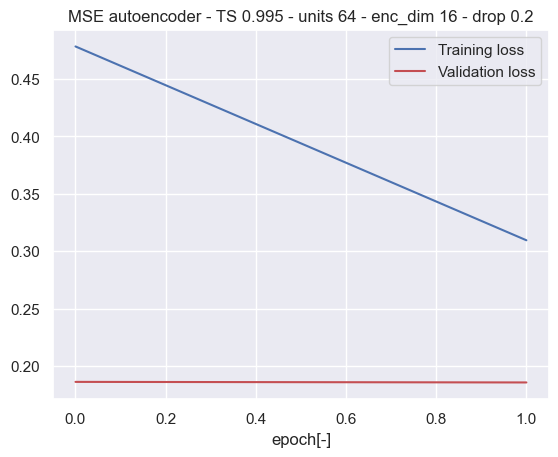

MSE TEST :  0.18583841621875763
Save autoencoder:  data/mdl_autoencoder
INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


Save encoder:  data/mdl_encoder


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


Load models...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 16)          43792     
                                                                 
 model_1 (Functional)        (None, None, 102)         27366     
                                                                 
Total params: 71158 (277.96 KB)
Trainable params: 71158 (277.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          42752     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 dense (Dense)               (None, None, 16)          1040      
                                                                 
Total params: 43792 (171.06 KB)
Trainable params: 43792 (171.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model : n_unit:64 / enc_dim: 16 / dropout: 0.2
Best model : seed:1 / n_unit:64 / enc_dim: 16 / dropout: 0.2


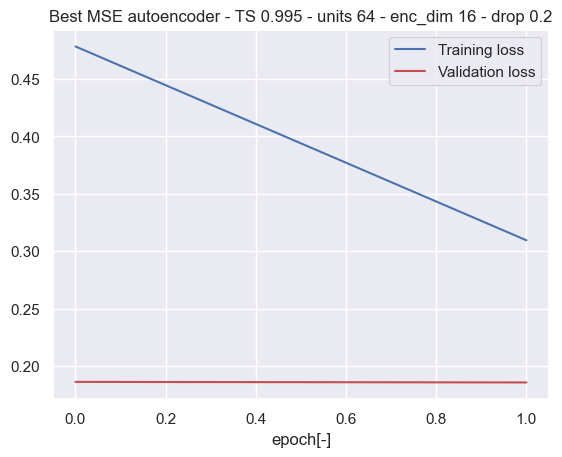

In [28]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
#epochs = 500 #100 #150 #6 #300
#patience = 0 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in LIST_UNITS_AE: #[32, 64, 128]: #[104]: #
        for encoding_dim in LIST_UNITS_ENC_AE:#[16, 20, 32]:
            for dropout_autoenc in LIST_DROPOUT_AE: #[0.05, 0.15, 0.25]: #[0.25]:
                for seed in LIST_SEEDS:
                    # check already done ? 
                    #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                    plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                    path_jpg = os.path.join(path_data,
                        f"output_MSE autoencoder - {plt_name}.jpg")
                    if (MODE_TRAIN_AE == False):
                        print(f"BE CAREFUL ! training inactivated => no training done...")
                        continue
                    print(f"Training: {plt_name} ...")
                    # Init
                    tf.keras.backend.clear_session()
                    np.random.seed(seed)
                    random.seed(seed)
                    tf.random.set_seed(seed)
                    # Input dimension
                    input_dim = train_data_ae.element_spec[0].shape[-1]
                    # Reduced encoded input dimension
                    # 64/8/0.5
                    # Définir l'encodeur
                    encoder_inputs = keras.Input(shape=(None, input_dim))
                    encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                    #encoder = layers.LayerNormalization()(encoder)
                    #encoder = layers.Dense(encoding_dim, activation='relu')
                    encoder = layers.Dropout(dropout_autoenc)(encoder)
                    encoder_outputs = layers.Dense(encoding_dim)(encoder)
                    encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                    print(encoder_model.summary())
                    # Définir le décodeur
                    decoder_inputs = keras.Input(shape=(None, encoding_dim))
                    decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                    #decoder = layers.LayerNormalization()(decoder)
                    #decoder = layers.Dense(n_unit_enc, activation='relu')
                    decoder = layers.Dropout(dropout_autoenc)(decoder)
                    decoder_outputs = layers.Dense(input_dim)(decoder)
                    decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                    print(decoder_model.summary())
                    # Define complete autoencoder 
                    autoencoder_inputs = keras.Input(shape=(None, input_dim))
                    encoded = encoder_model(autoencoder_inputs)
                    decoded = decoder_model(encoded)
                    autoencoder = keras.Model(autoencoder_inputs, decoded)
                    # Compile : autoencoder
                    optim = tf.keras.optimizers.legacy.Adam()
                    #optim = tf.keras.optimizers.AdamW()
                    #optim = tf.keras.optimizers.Adam()
                    autoencoder.compile(optimizer=optim, loss="mse")
                    # earlystop 
                    es = EarlyStopping(patience=PATIENCE_AE, verbose=2, min_delta=0.001, 
                                    monitor='val_loss', mode='auto', restore_best_weights=True)
                    # Train
                    if PATIENCE_AE == 0:
                        autoenc_step_history = autoencoder.fit(
                            train_data_ae.cache().shuffle(len_train).batch(BATCH_SIZE),
                            epochs=EPOCHS_AE,
                            steps_per_epoch=math.floor(len_train / BATCH_SIZE),
                            validation_data=test_data_ae.cache().batch(BATCH_SIZE),
                            validation_steps=1,
                            verbose=1,
                        )
                    else:
                        autoenc_step_history = autoencoder.fit(
                            train_data_ae.cache().shuffle(len_train).batch(BATCH_SIZE),
                            epochs=EPOCHS_AE, 
                            batch_size=BATCH_SIZE, 
                            validation_data=test_data_ae.cache().batch(BATCH_SIZE),
                            verbose=1, callbacks=[es])

                    plot_train_history(
                        autoenc_step_history,f"MSE autoencoder - {plt_name}",
                        saveFolder=path_data)
                    #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                    #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                                # save the best
                    mse_curr = np.min(autoenc_step_history.history['val_loss'])
                    print("MSE TEST : ", mse_curr)

                    if mse_curr_min == None:
                        seed_min = seed
                        autoenc_step_history_min = autoenc_step_history
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)
                    else:
                        if mse_curr < mse_curr_min:
                            seed_min = seed
                            autoenc_step_history_min = autoenc_step_history
                            mse_curr_min = mse_curr
                            n_unit_enc_min = n_unit_enc
                            encoding_dim_min = encoding_dim
                            dropout_autoenc_min = dropout_autoenc
                            print("Save autoencoder: ", path_mdl_autoencoder)
                            autoencoder.save(path_mdl_autoencoder)
                            print("Save encoder: ", path_mdl_encoder)
                            encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min

print("Load models...")
autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
print(autoencoder.summary())
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print(encoder_model.summary())
n_unit_enc = encoder_model.layers[1].units
dropout_autoenc = encoder_model.layers[2].rate
encoding_dim = encoder_model.layers[3].units
print(f"Model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

if MODE_TRAIN_AE:
    print(f"Best model : seed:{seed} / n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")
    plot_train_history(
        autoenc_step_history_min, 
        f"Best MSE autoencoder - {plt_name}",
        saveFolder=path_data,
    )

In [29]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [30]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


### Results

In [31]:
X_train_sca = [elem for elem, _ in train_data_ae.cache().batch(1).take(1).as_numpy_iterator()]
X_train_sca = X_train_sca[0]
X_train_sca.shape

2023-12-06 16:31:32.710320: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(1, 72, 102)

In [32]:
X_train_sca_pred = autoencoder.predict(train_data_ae.cache().batch(1).take(1))
X_train_sca_pred.shape

2023-12-06 16:31:33.168337: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 1s 873ms/step


(1, 72, 102)

In [33]:
'''X_train = np.empty([X_train_sca_pred.shape[0], X_train_sca_pred.shape[2]])
idx = 0
for elem, _ in train_data_ae.as_numpy_iterator():
    print(elem.shape)
    break
    X_train[idx,:,:] = elem
    idx += 1'''


'X_train = np.empty([X_train_sca_pred.shape[0], X_train_sca_pred.shape[2]])\nidx = 0\nfor elem, _ in train_data_ae.as_numpy_iterator():\n    print(elem.shape)\n    break\n    X_train[idx,:,:] = elem\n    idx += 1'

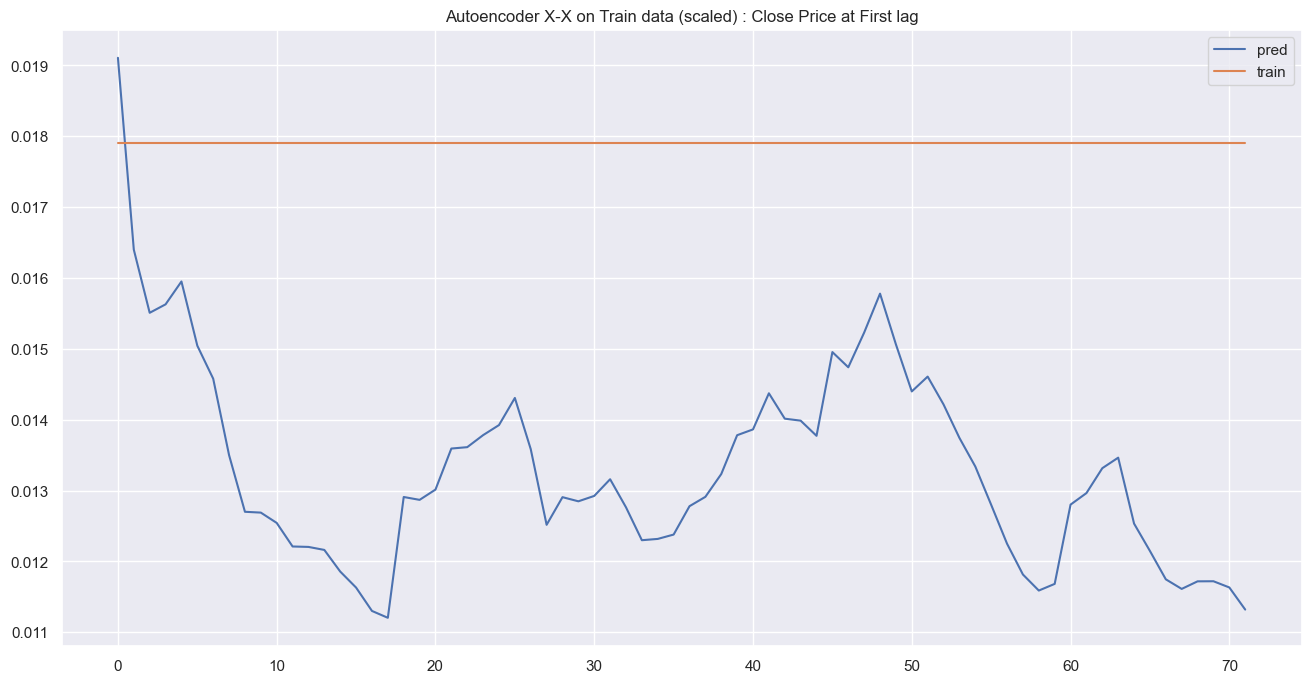

In [34]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[0,:,0], label="pred")
plt.plot(X_train_sca[0,:,0], label="train")
plt.legend(loc='upper right')

## Prediction Models

### Autoencoder + LSTM reduced features

In [36]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [38]:
class TimeSeriesDatasetForPredAe(tf.data.Dataset):
    # TODO : use Scaler for encorder dataset
    def _generator(data_matrix, seq_length, len_pred):
        
        num_elements = data_matrix.shape[0] # nb samples

        for start, stop, start_label, stop_label in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred),
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            label_matrix = data_matrix[start_label:stop_label, 0]
            yield (out_matrix, label_matrix)
       

    def __new__(cls, data_matrix, seq_length, len_pred):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=(
                tf.TensorSpec(
                    shape = (seq_length, data_matrix.shape[1]),
                    dtype = tf.float32,
                ),
                tf.TensorSpec(
                    shape = (seq_length, len_pred),
                    dtype = tf.float32,
                ),
            ),
            args=(data_matrix, seq_length, len_pred),
        )

In [39]:
train_data_ae_lstm = TimeSeriesDatasetForPredAe(arr_train, PAST_HISTORY, FUTURE_TARGET)

In [40]:
train_data_ae_lstm.cache().batch(1).take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 72, 102), dtype=tf.float32, name=None), TensorSpec(shape=(None, 72, 15), dtype=tf.float32, name=None))>

In [133]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

2729/2729 [==============================] - 30s 11ms/step


(87313, 72, 64)

In [134]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

11/11 [==============================] - 0s 22ms/step


(351, 72, 64)

In [135]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [136]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [137]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [138]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((87313, 72, 68), (351, 72, 68))

#### Correlations

In [139]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



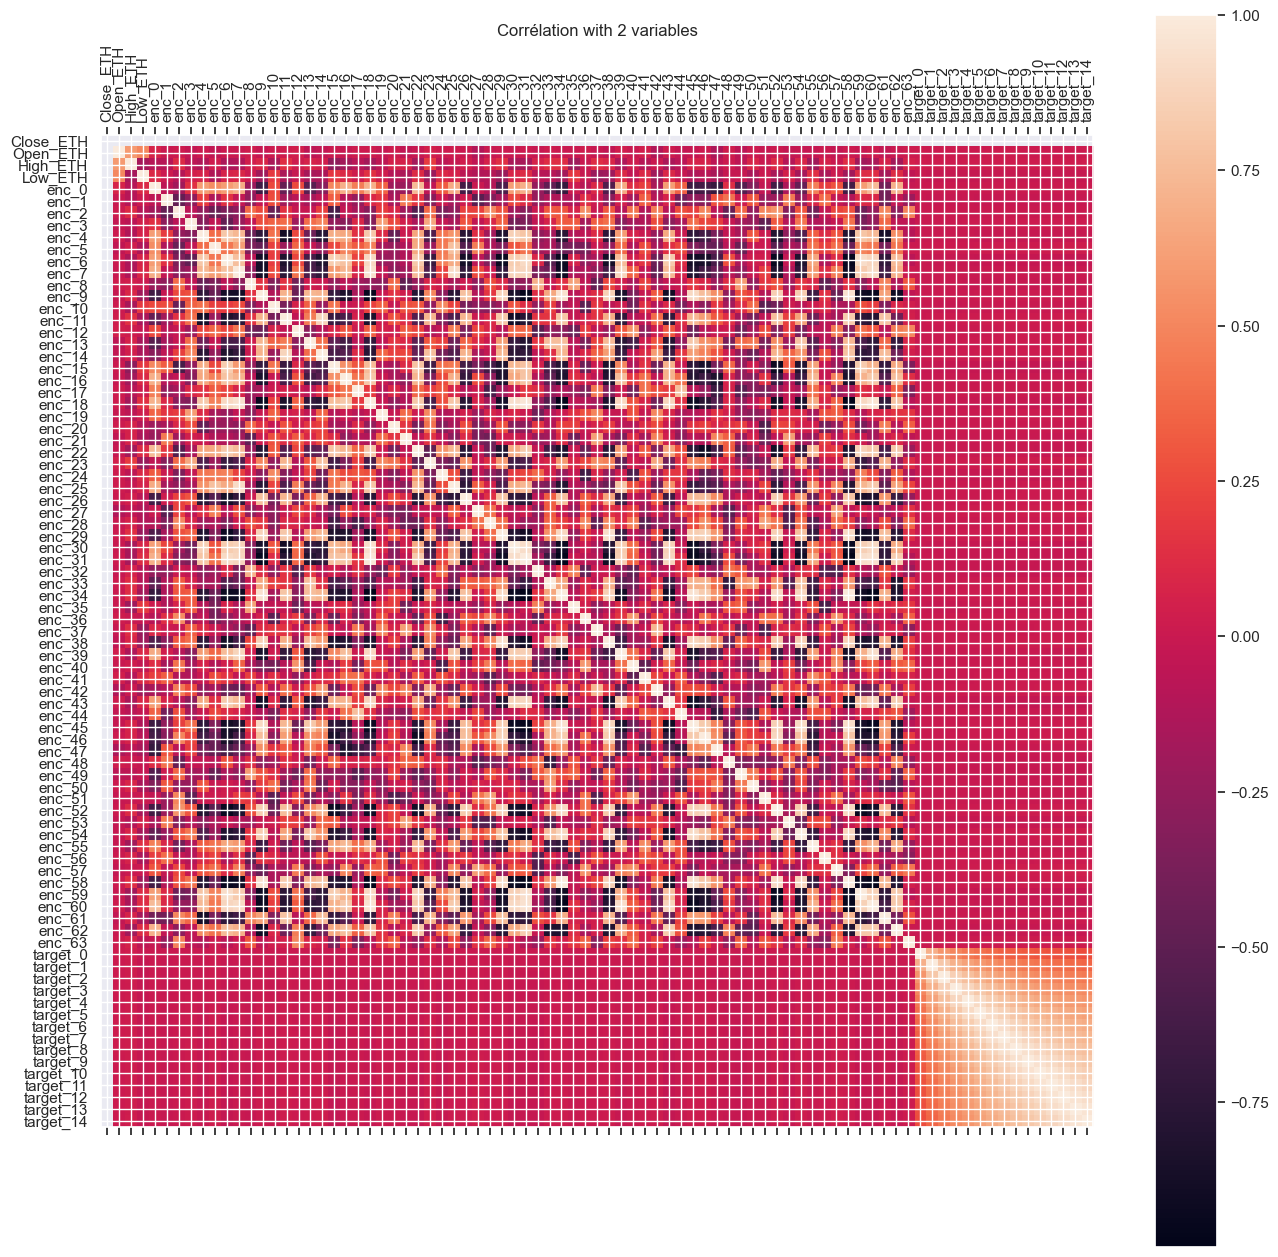

In [140]:
fig = plot_corr(corr_matrix_min)

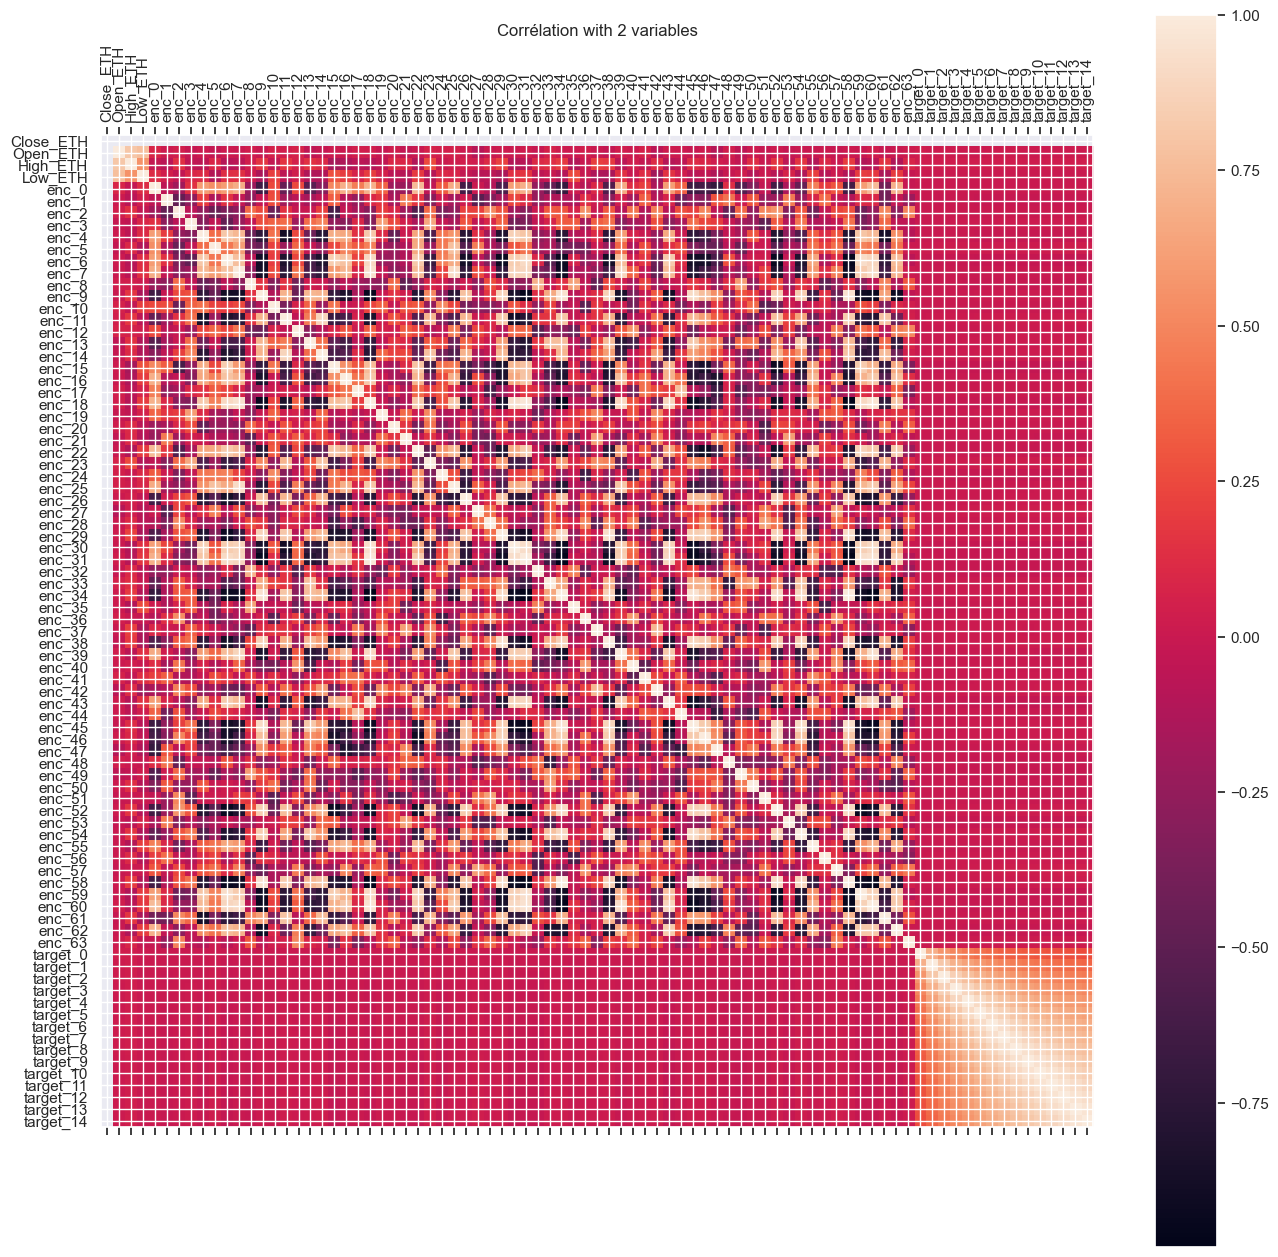

In [141]:
fig = plot_corr(corr_matrix_max) 

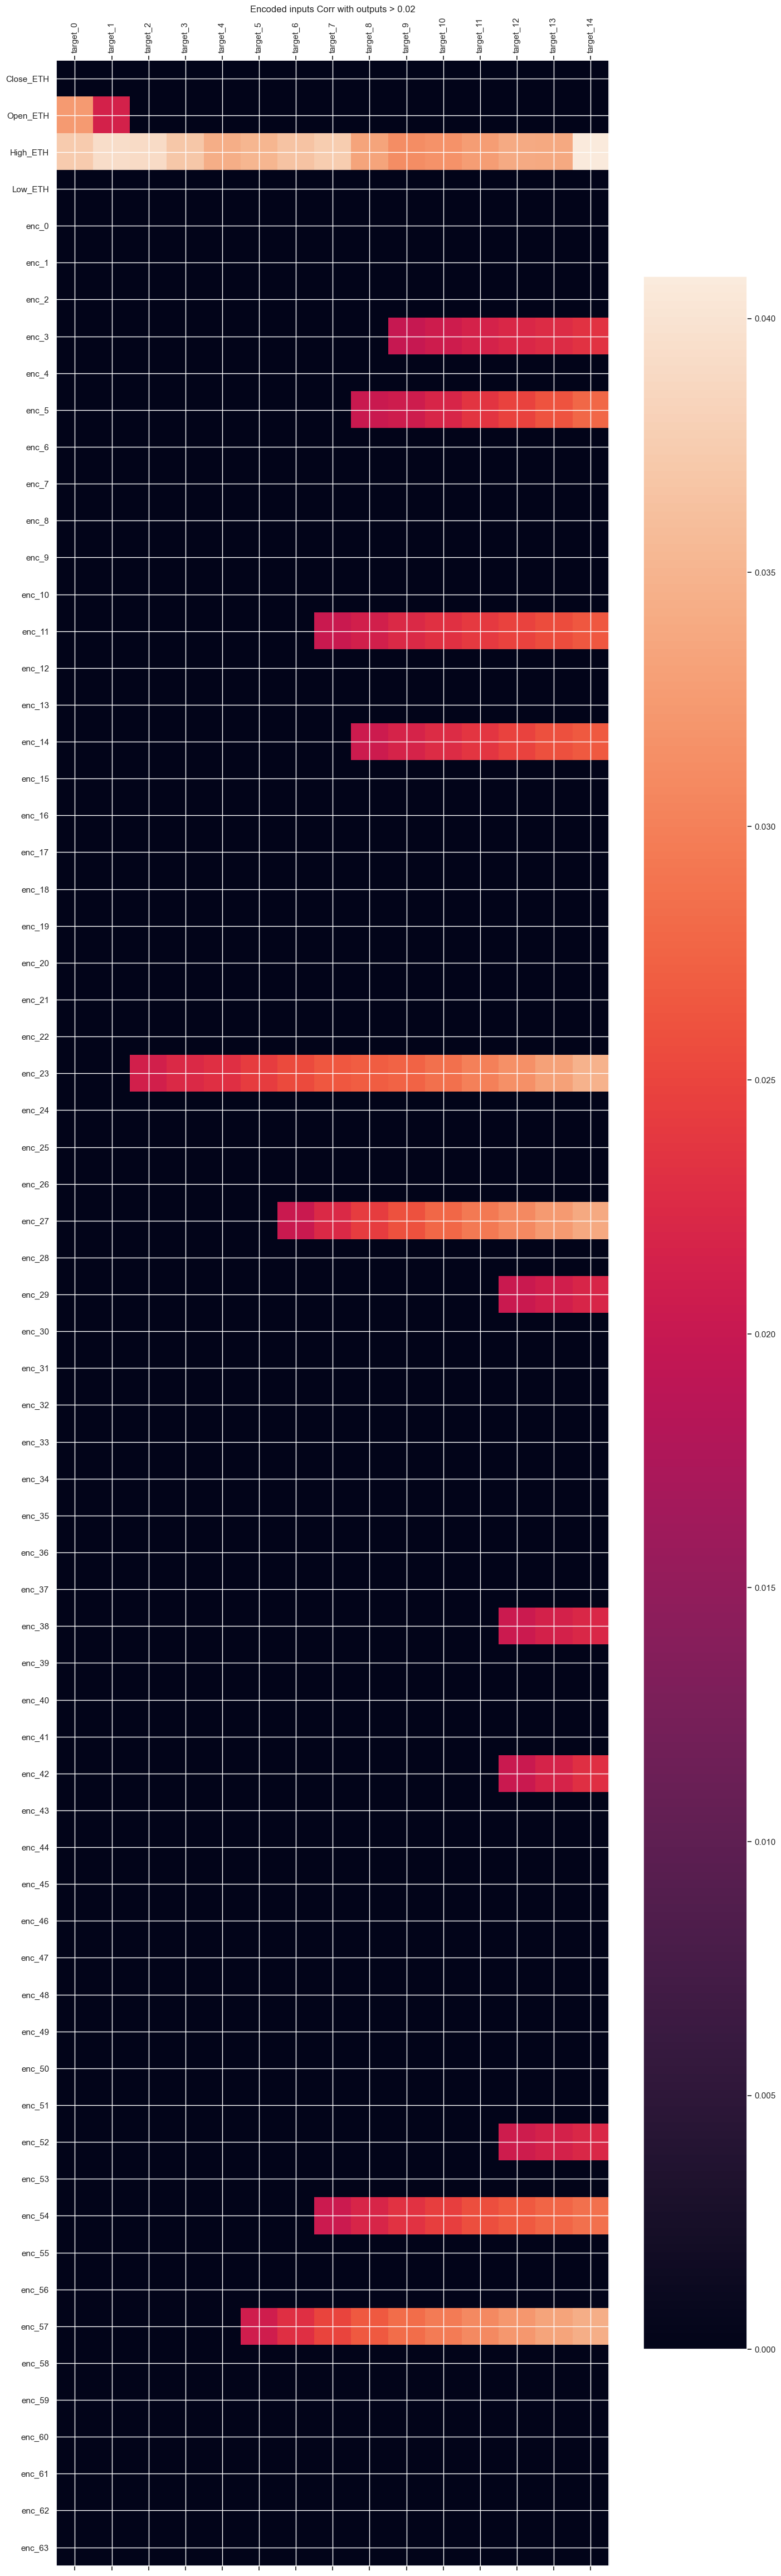

In [142]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

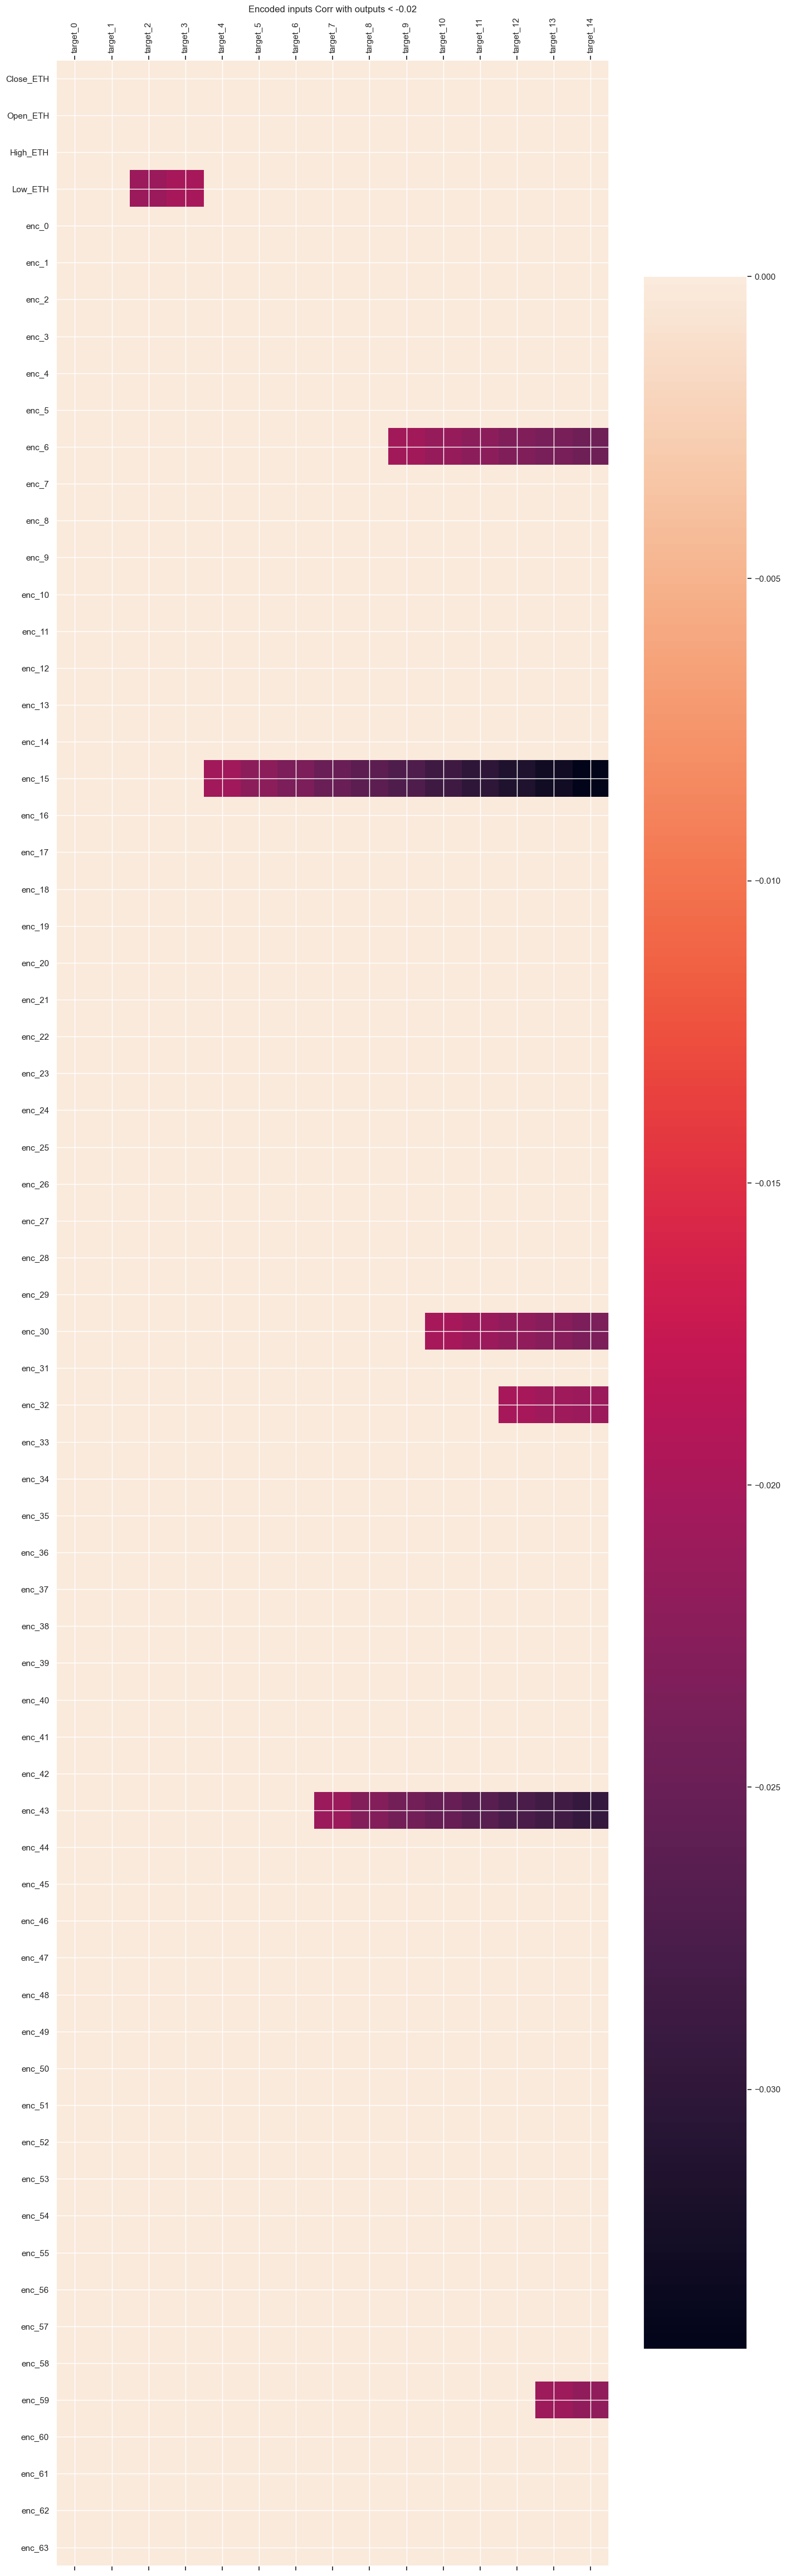

In [143]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [144]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [145]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [146]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [147]:
MODE_AUTO_SELECT

0

In [148]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
nb encoded features:  64


In [149]:
X_train_.shape

(87313, 72, 68)

In [150]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

In [151]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [152]:
X_train_.shape

(87313, 72, 68)

#### Train

In [153]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)

mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in LIST_UNITS_PRED: #[32, 64, 128]: #[128]: #
        for dropout_rate in  LIST_DROPOUT_PRED: #[0.05, 0.15, 0.25]: #[0.1]:
            for seed in LIST_SEEDS:
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.AdamW()
                if PATIENCE_PRED is not None:
                    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                    verbose=1, patience=PATIENCE_PRED,
                                                    restore_best_weights=True)
                # create model
                multi_step_model = tf.keras.models.Sequential()
                multi_step_model.add(
                    tf.keras.layers.LSTM(
                        n_units,
                        return_sequences=False,
                        input_shape=X_train_.shape[-2:],
                        #kernel_regularizer=reg,
                        #bias_regularizer=reg,
                    )
                )
                multi_step_model.add(tf.keras.layers.LayerNormalization())
                multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
                #multi_step_model.add(tf.keras.layers.BatchNormalization())
                multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
                # compile
                multi_step_model.compile(optimizer=optim, loss='mse')
                # fitting
                if PATIENCE_PRED == 0:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1,
                    )
                else:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1, 
                        callbacks=[es],
                    )
                # eval
                if PATIENCE_PRED !=0:
                    # mode min val loss
                    i_epoch = np.argmin(multi_step_history.history['val_loss'])
                    mse_curr_train = multi_step_history.history['loss'][i_epoch]
                    mse_curr = multi_step_history.history['val_loss'][i_epoch]
                else:
                    # mode last
                    mse_curr_train = multi_step_history.history['loss'][-1]
                    mse_curr = multi_step_history.history['val_loss'][-1]

                print("MSE TRAIN : ", mse_curr_train)
                print("MSE TEST : ", mse_curr)
                    
                # plot MSE
                name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                plot_train_history(
                    multi_step_history,
                    f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                    saveFolder="data",
                )

                # save the best
                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate

                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_units_min = n_units
                        dropout_rate_min = dropout_rate
                        print("Save model: ", path_mdl_predict_autoenc_lstm)
                        multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

    
print("Load model: ", path_mdl_predict_autoenc_lstm)
multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
n_units = multi_step_model.layers[0].units#32
dropout_rate = multi_step_model.layers[2].rate#0.25
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=128 / dropout= 0.2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               100864    
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 103055 (402.56 KB)
Trainable params: 103055 (402.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [154]:
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=128 / dropout= 0.2


In [155]:
np.min(y_train)

0.8990060972444147

In [156]:
np.max(y_train)

1.087790104524251

#### Results

##### Save mdl

In [157]:
X_train_.shape

(87313, 72, 68)

##### Predict

In [158]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

11/11 [==============================] - 0s 23ms/step


##### Plots

In [159]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(87315,)
(87315,)


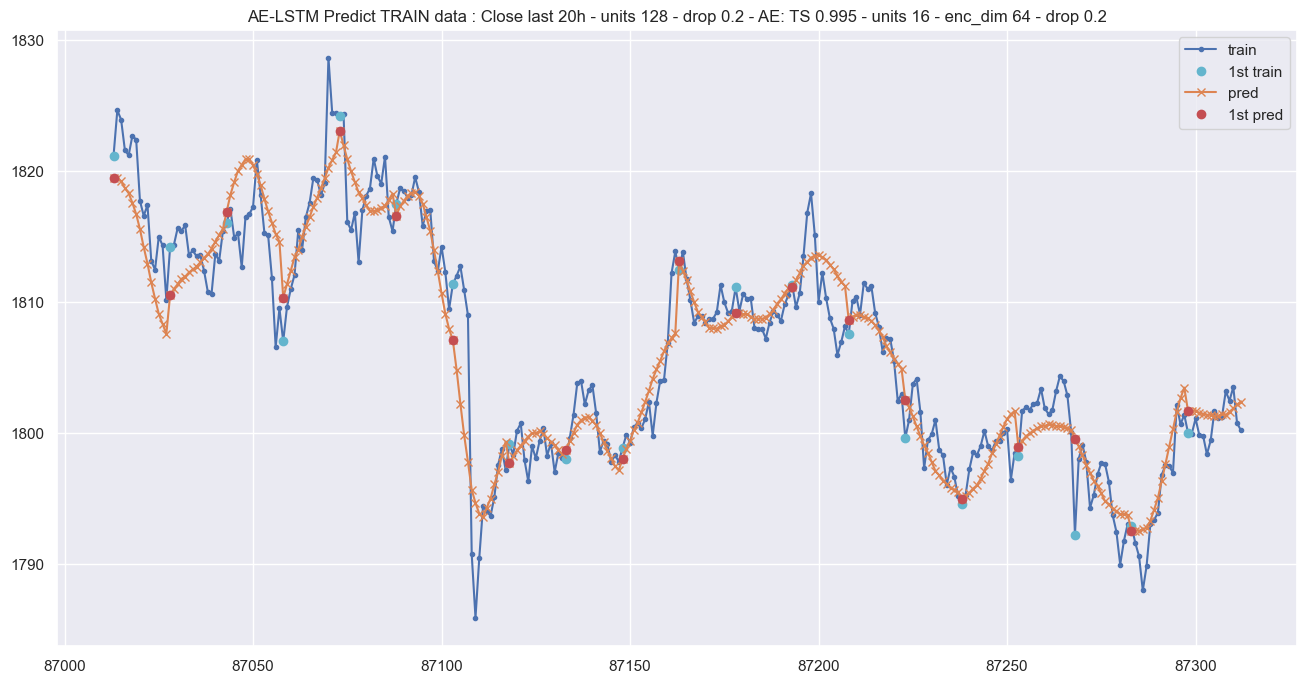

In [160]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

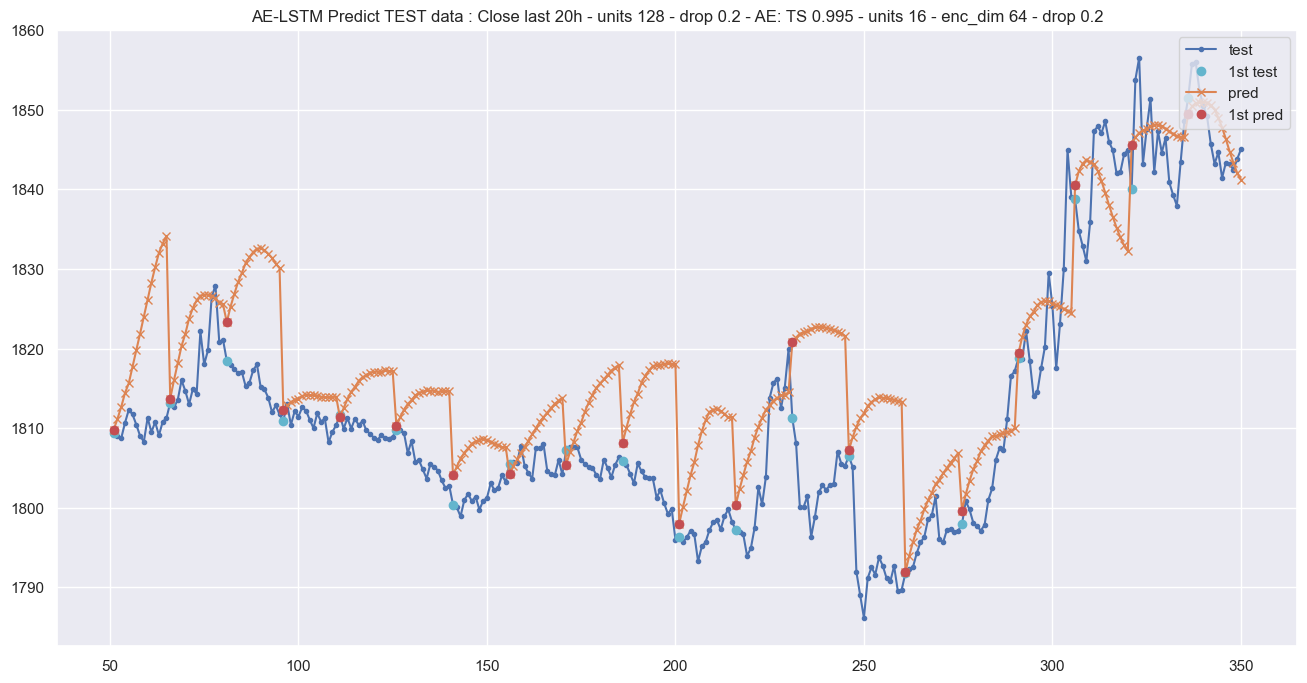

In [161]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

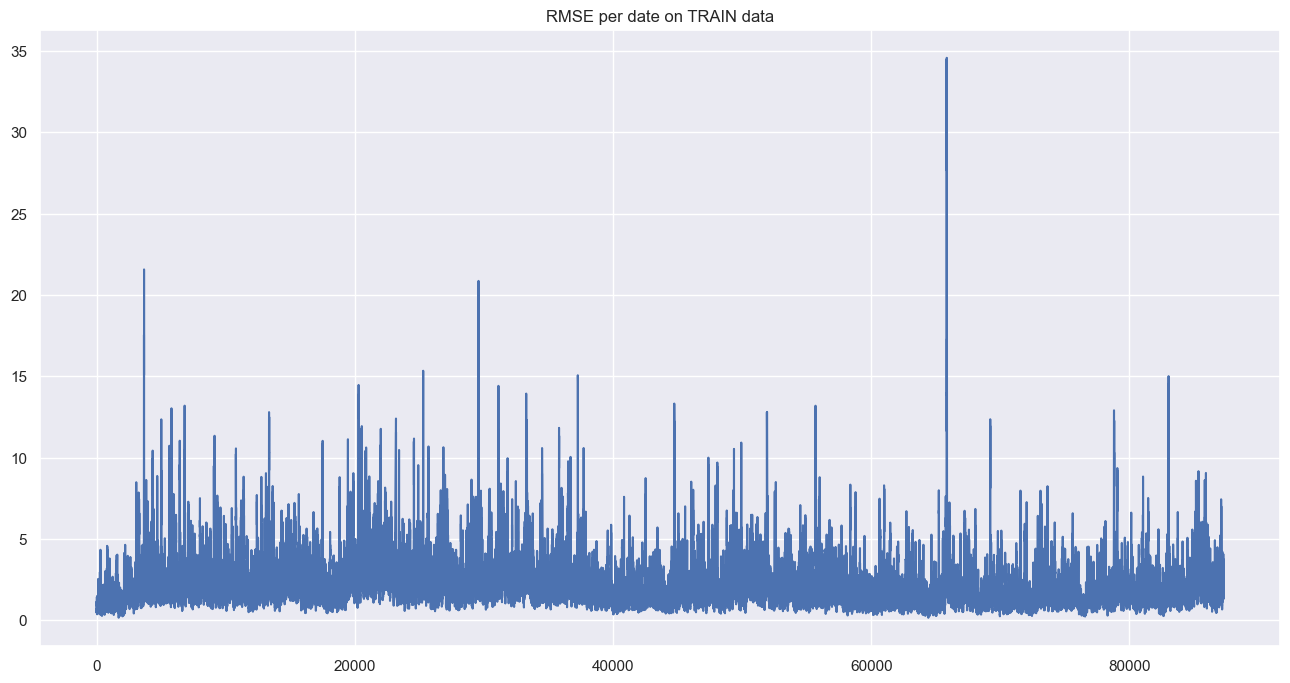

In [162]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

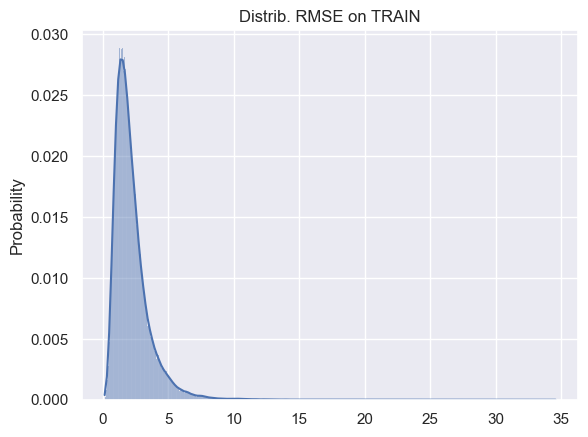

In [163]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 2.22')

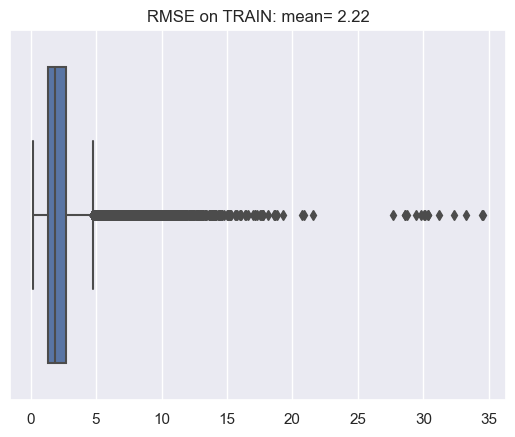

In [164]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

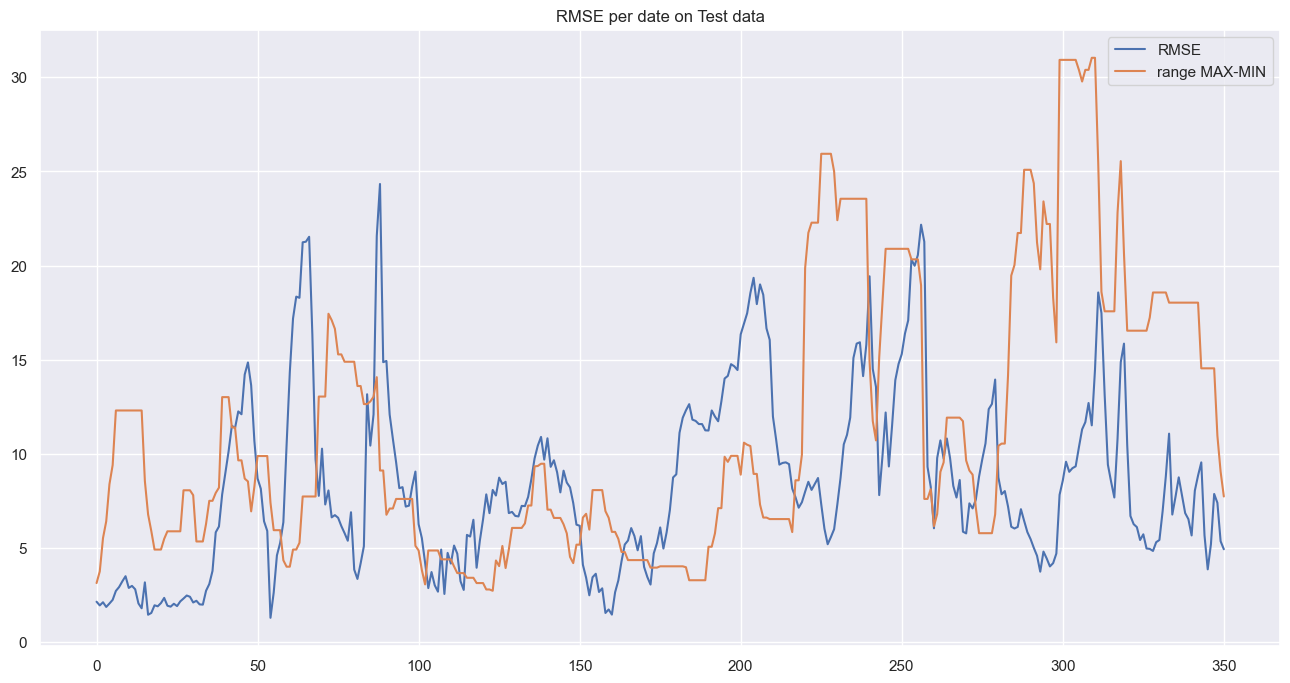

In [165]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [166]:
np.mean(arr_range)

11.437207977207965

<Axes: ylabel='Probability'>

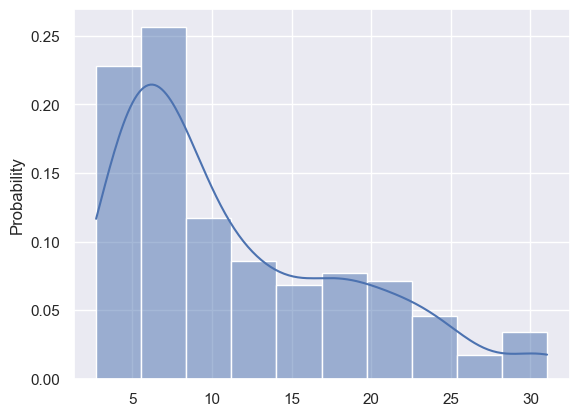

In [167]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [168]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

9.968012701114551

<Axes: ylabel='Probability'>

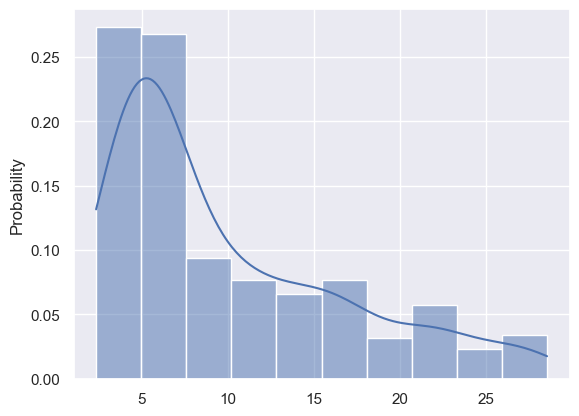

In [169]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

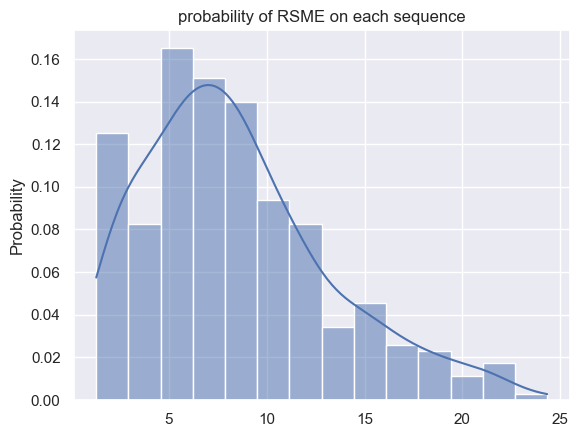

In [170]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 57.18603988603982)

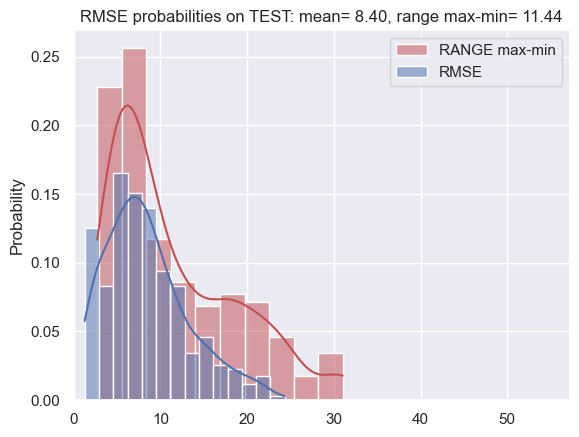

In [171]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 42.019147872271446)

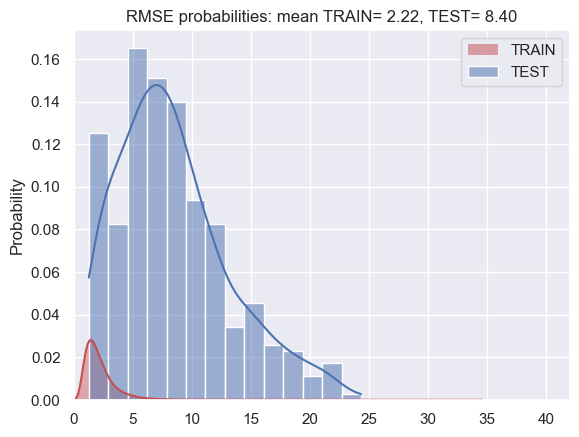

In [172]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 8.40')

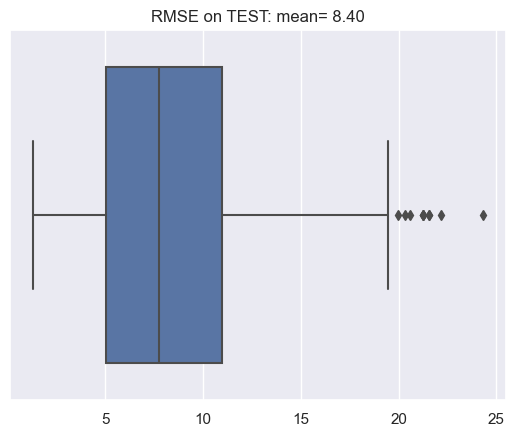

In [173]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [174]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1852.41 1850.5  1849.18 1845.7  1843.21 1844.65 1841.45 1843.36 1843.15
 1842.48 1843.8  1845.03 1845.75 1846.39 1845.32]
[1855.59097337 1855.59285401 1855.27779223 1854.92965339 1854.6300792
 1854.30207422 1853.82129525 1853.15566087 1851.97196669 1850.78163497
 1849.45412747 1848.0200875  1846.72233829 1845.63123776 1844.90232552]


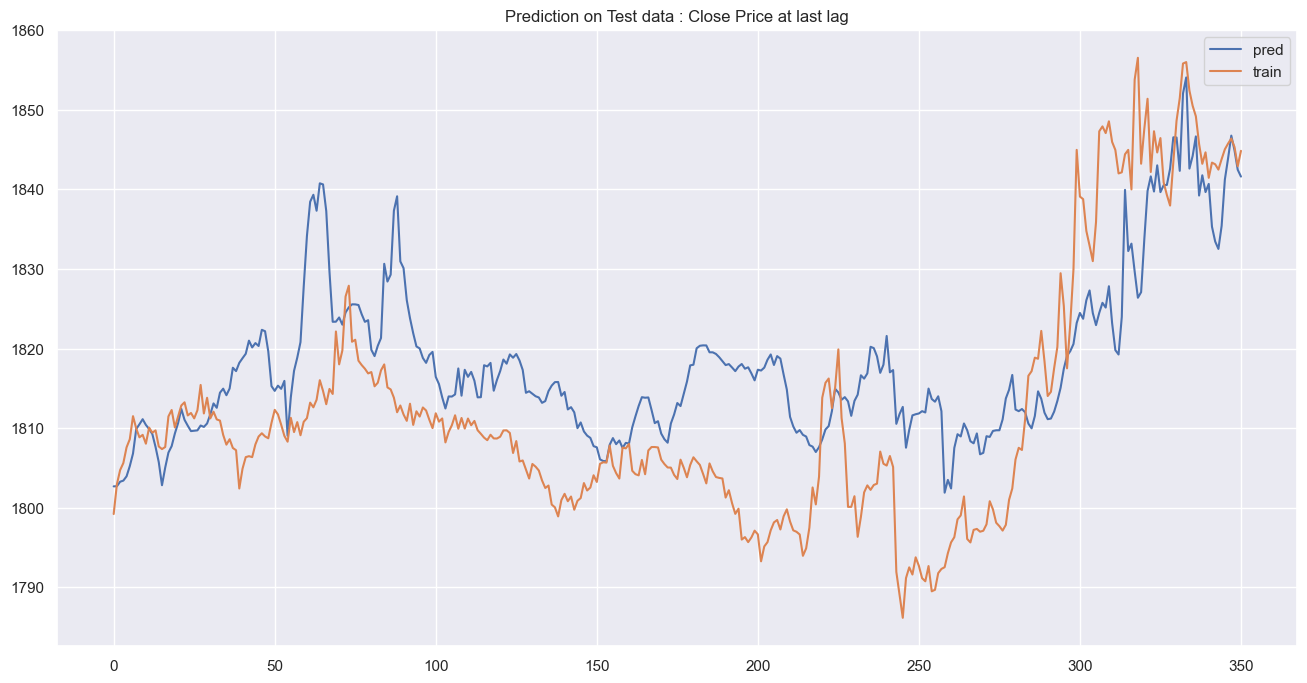

In [175]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

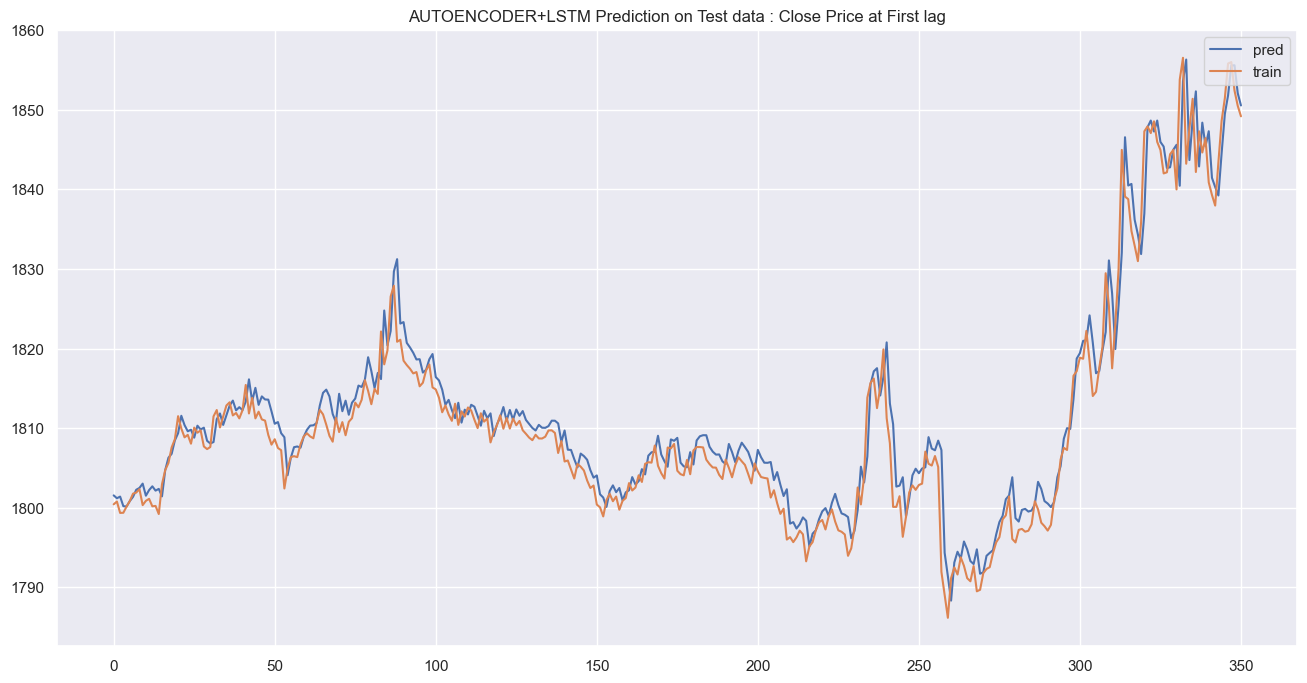

In [176]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

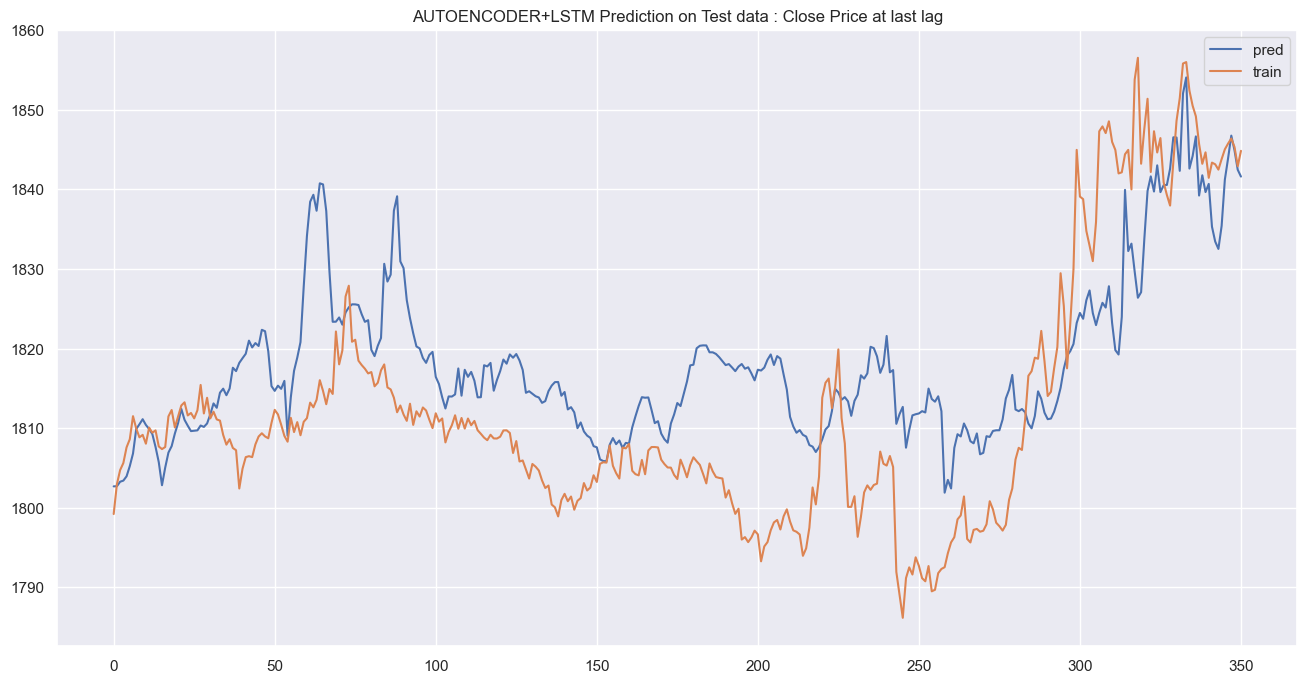

In [177]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [178]:
X_test_sca.shape

(351, 72, 102)

In [179]:
df_feat["Close_ETH"].iloc[-1]

1845.18

In [180]:
df_feat["Close_ETH"].iloc[-1]

1845.18

In [181]:
len(list_i_enc_select)

64

In [182]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1806.05 1807.52 1807.25 1811.15 1816.57 1817.15 1818.85 1818.71 1822.21
 1818.4  1814.03 1814.56 1817.54 1820.2  1829.46 1825.35 1817.51 1823.09
 1829.95 1844.96 1839.09 1838.77 1834.77 1832.92 1830.98 1835.9  1847.29
 1847.91 1847.07 1848.55 1845.96 1844.95 1842.   1842.14 1844.41 1844.96
 1839.99 1853.79 1856.53 1843.22 1847.63 1851.38 1842.18 1847.3  1844.63
 1846.44 1840.87 1839.29 1837.96 1843.42 1848.62 1851.46 1855.81 1855.99
 1852.41 1850.5  1849.18 1845.7  1843.21 1844.65 1841.45 1843.36 1843.15
 1842.48 1843.8  1845.03 1845.75 1846.39 1845.32 1842.9  1844.84 1845.18]
X_last[0,:,0] after divide by price:
[0.9787934  0.97959007 0.97944374 0.98155735 0.98449474 0.98480907
 0.98573039 0.98565452 0.98755135 0.98548651 0.98311818 0.98340541
 0.98502043 0.98646203 0.99148051 0.98925308 0.98500417 0.98802827
 0.99174606 0.99988077 0.99669951 0.99652608 0.99435827 0.99335566
 0.99230427 0.99497068 1.00114352 1.00147953 1.00102429 1.00182638
 1.0

In [183]:
X_last_encoded_sca.shape

(1, 72, 64)

In [184]:
list_i_enc_select

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63]

In [185]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 64)

In [186]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [187]:
X_train_.shape

(87313, 72, 68)

In [188]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1727.214729,1726.792302,1194.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1727.214729,1726.792302,1194.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1727.214729,1726.792302,1194.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1727.214729,1726.792302,1194.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1727.214729,1726.792302,1194.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87833,1698881100000,1845.75,1848.00,1845.65,1846.39,1115.4933,2023-11-01 23:25:00,1842.800000,1826.145000,1847.06,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
87834,1698881400000,1846.39,1846.89,1844.37,1845.32,828.6682,2023-11-01 23:30:00,1842.812500,1826.145000,1847.06,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
87835,1698881700000,1845.31,1846.09,1841.57,1842.90,1247.9121,2023-11-01 23:35:00,1844.047500,1826.145000,1847.06,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
87836,1698882000000,1842.91,1845.19,1841.72,1844.84,1012.7918,2023-11-01 23:40:00,1844.752500,1826.145000,1847.06,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False


In [189]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [190]:
y_last_pred_unscaled

array([[0.99960524, 0.999216  , 0.99877805, 0.99836564, 0.99807155,
        0.9976622 , 0.99741733, 0.9970761 , 0.99657613, 0.9961755 ,
        0.9957284 , 0.99514073, 0.9944918 , 0.9939701 , 0.99355096]],
      dtype=float32)

In [191]:
df_feat["Close_ETH"].iloc[-1]

1845.18

In [192]:
y_last_pred_raw

array([[1844.4517, 1843.7335, 1842.9253, 1842.1643, 1841.6217, 1840.8663,
        1840.4146, 1839.7849, 1838.8624, 1838.1232, 1837.2981, 1836.2139,
        1835.0165, 1834.0538, 1833.2804]], dtype=float32)

In [193]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [194]:
list_pred

[1842.1643,
 1841.6217,
 1840.8663,
 1840.4146,
 1839.7849,
 1838.8624,
 1838.1232,
 1837.2981,
 1836.2139,
 1835.0165,
 1834.0538,
 1833.2804]

In [195]:
save_list(list_pred, path_save_pred_vals)

In [196]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [197]:
list_pred_reload

[1842.1643,
 1841.6217,
 1840.8663,
 1840.4146,
 1839.7849,
 1838.8624,
 1838.1232,
 1837.2981,
 1836.2139,
 1835.0165,
 1834.0538,
 1833.2804]